# Raw Data

In [1]:
import csv
from os import listdir
from os.path import isfile, join
import json
source_data_path = '/Users/weizhechen/Desktop/KKMA/'
metadata_folder = 'metadata'
movie = []
count = 0
concat_folder = join(source_data_path,metadata_folder)
for filename in listdir(concat_folder):
    if 'branch_movie' not in filename and 'branch_series' not in filename:
        continue
    if count % 30 == 0:
        print(f'process{count}')
    count += 1
    with open(join(concat_folder,filename),'r',encoding='utf-8') as fp:
        for line in fp.readlines():
            data = json.loads(line)
            movie.append(data)
print(len(movie))

process0
process30
process60
process90
process120
112290


In [2]:
import pandas as pd
movie_and_series_df = pd.DataFrame(movie)
genere_df = pd.read_csv('/Users/weizhechen/Desktop/KKMA/Genre_20190806.csv')

In [3]:
# 標記是否有artist以及genre
have_artists = list(movie_and_series_df['artists'].notnull())
have_genre_ids = list(movie_and_series_df['genre_ids'].notnull())
dict = {
    'have_artists':have_artists,
    'have_genre_ids':have_genre_ids
}
df = pd.DataFrame(dict)
movie_and_series_df = pd.merge(df, movie_and_series_df ,how='outer',left_index=True, right_index=True)
len(movie_and_series_df) # 原本所有電影總數

112290

In [4]:
clean_movie_and_series_df = movie_and_series_df[(movie_and_series_df.have_genre_ids == True)
                & (movie_and_series_df.have_artists == True) ].reset_index(drop=True)
len(clean_movie_and_series_df) # 去除沒有genre 和 artist後所剩總數

36434

In [5]:
# 留下{'', 'G', 'R-18', 'R-15', 'PG-12', ''}
import numpy as np
lst = clean_movie_and_series_df['content_rating'].to_list()
content_rating_list = np.array(lst)
rating_list_index = np.where((content_rating_list == 'R-20') | (content_rating_list == 'R-18E'))
len(list(rating_list_index)[0]) #去除R-20 R-18E

12315

In [6]:
legitimat_df = clean_movie_and_series_df.drop(clean_movie_and_series_df.index[list(rating_list_index)]).reset_index(drop=True)

/Users/weizhechen/opt/anaconda3/envs/pytorch_envs/lib/python3.8/site-packages/pandas/core/indexes/base.py:5055: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


In [7]:
len(legitimat_df)# 所剩合法電影總數

24119

In [8]:
dd = clean_movie_and_series_df['artists'].to_list()
all_name = []
for name_list in dd:
    for name in name_list:
        all_name.append(name)
len(set(all_name)) #總演員數

91538

In [9]:
j = 0
all_artists = list(set(all_name))
number = set([str(i) for i in range(10)])
for i in range(len(all_artists)):
    for num in number:
            if num in all_artists[i]:
                j +=1
j #可疑演員總數

2492

In [10]:
all_count = 0
valid_count = 0
strange_artist = []
j = 0 
number = set([str(i) for i in range(10)])
movie_length = len(movie)
print(movie_length)
for i in range(movie_length):

    if movie[i]['artists'] == None:
        continue

    for artist in movie[i]['artists']:
        all_count += 1
        valid = True
        for num in number:
            if num in artist:
                strange_artist.append(artist)
                valid = False
                break
        if valid:
            valid_count += 1
#             print(artist)

print(all_count)
print(valid_count) #可疑演員總數

112290
410261
406444


In [11]:
strange_artist[0:20] #可疑演員內容

['計22人',
 '6名',
 'AIKA 他計7名',
 '30名',
 '10GAUGE',
 '一見清楚なM婦人3人',
 '豪華女優33人',
 '4名',
 '4名',
 '素●12人',
 '6名',
 '超絶美貌の女子大生3人',
 '歪んだ愛情をむけられた義母6人',
 '五十路六十路義母30人',
 '60名',
 '飯島麗華 他計8人',
 '人妻モデル4人',
 '美人で可愛いお姉さま4人',
 'ヨガインストラクター15人',
 '4名']

In [12]:
df_list = legitimat_df['artists'].to_list()
artists_list = np.array(df_list)

/var/folders/f3/m87mf4rx0w17bqc2l_gc5lm80000gp/T/ipykernel_15662/4008358145.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  artists_list = np.array(df_list)


In [13]:
strange_nameindex = []
i = 0
for movie_artist in artists_list:
    for artist_name in movie_artist:
        if artist_name in set(strange_artist):
            i +=1
i

475

In [14]:
all_artist_name = [] #用來製作matrix所需演員名單
for name_list in df_list:
    for name in name_list:
        all_artist_name.append(name)
len(set(all_artist_name)) #所有合法電影中演員總數

82580

# 篩選合法行為

In [15]:
interaction_df = pd.read_csv('/Users/weizhechen/Desktop/KKMA/interactions_test.csv')

In [16]:
interaction_df
legitimat_id = legitimat_df['id'].to_list()
len(legitimat_id)

24119

In [17]:
illegal_ID_index = []
ID_list = interaction_df['item_id'].to_list()
length = len(ID_list)
for i in range(length):
    if ID_list[i] not in set(legitimat_id):
        illegal_ID_index.append(i)

In [18]:
clean_interaction_df = interaction_df.drop(index=illegal_ID_index).reset_index(drop=True)

In [19]:
len(clean_interaction_df),len(interaction_df) #所剩可比對的行為與全部行為

(4299, 9999)

In [20]:
Group_id = clean_interaction_df.groupby('user_id')
user_ids = list(Group_id.groups.keys())
len(user_ids) #所有使用者的id

2783

In [21]:
string = 'user_id'
freq = clean_interaction_df.groupby([string]).count() 
freq

,item_id,item_type,play_amount_second,client_upload_timestamp,server_upload_timestamp,interaction,pt
user_id,,,,,,,
0,6,6,6,6,6,6,6
0110030253-001CFCDD6750,1,1,1,1,1,1,1
0110034696-001CFC7974F8,1,1,1,1,1,1,1
0110044707-001CFC761498,2,2,2,2,2,2,2
0110104037-001CFC73C5BC,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...
932556,3,3,3,3,3,3,3
941475,2,2,2,2,2,2,2
968792,1,1,1,1,1,1,1


In [22]:
illegal_genre_index = []
genere_list = genere_df['RatingValue'].to_list()
length = len(genere_list)
for i in range(length):
    if genere_list[i] == 'R-20':
        illegal_genre_index.append(i)
len(illegal_genre_index) #非法genre總數

95

In [23]:
clean_genre_df = genere_df.drop(index=illegal_genre_index).reset_index(drop=True)
set(clean_genre_df['RatingValue']) #確認所有genre皆為合法

{'G'}

In [24]:
genre_ids = clean_genre_df['GenreID'].to_list() #全部合法genre ids 作為matrix使用
len(genre_ids)

373

# 製作 interaction_df

In [25]:
clean_interaction_df['artists'] = None
clean_interaction_df['genre_ids'] = None
clean_interaction_df['time_stamp'] = None

In [26]:
import time
def to_timestamp(r):
    timeString = r['client_upload_timestamp'][:-4]
    struct_time = time.strptime(timeString, "%Y-%m-%d %H:%M:%S") 
    time_stamp = int(time.mktime(struct_time))
    return time_stamp

In [27]:
clean_interaction_df['time_stamp'] = clean_interaction_df.apply(to_timestamp, axis=1)

In [28]:
clean_interaction_df = clean_interaction_df.drop(['play_amount_second', 'client_upload_timestamp','server_upload_timestamp'], axis=1) 

In [29]:
clean_interaction_df

,user_id,item_id,item_type,interaction,pt,artists,genre_ids,time_stamp
0,2474306,1wD4g4XsdIeWlGVfzRINtYmWcmY,series,click,2022-06-05,None,None,1654434806
1,3388774701-001CFC9B81B0,1iMUvTi1eRV8NlzImO0YBLxQL4d,series,play,2022-06-05,None,None,1654434811
2,3110051691-001CFCBC9B74,1TwKjfa78ggenBBeFKZ1EZ0stE1,series,click,2022-06-05,None,None,1654434811
3,3130706901-001CFCADEC74,1vOEFBWXhl8eBrmCVPgBRG19Rov,series,click,2022-06-05,None,None,1654434814
4,0827482101-001CFCDE737C,27PuwO5U0CX7Cl3OefgkzCDs6mj,series,play,2022-06-05,None,None,1654434818
...,...,...,...,...,...,...,...,...
4294,1562153101-001CFC846330,1TwKyJ6jN9n5I9GQX05c90hBTYO,movie,play,2022-06-05,None,None,1654403004
4295,6610054487-001CFC77EA80,26s1j4CF1K3xsYxJYyuITfT6W9a,series,play,2022-06-05,None,None,1654403004
4296,0143647402-001CFC7CD9B8,1tZG3JiNtcDF0ICMrZ588znwc1b,series,play,2022-06-05,None,None,1654403004
4297,3410075052-001CFC7B9624,1mpPsjqPDFfr7l0mcRdcU0R2cue,series,play,2022-06-05,None,None,1654403004


In [30]:
# item_type
# pt
string = 'pt'
freq = clean_interaction_df.groupby([string]).count() 
freq

,user_id,item_id,item_type,interaction,artists,genre_ids,time_stamp
pt,,,,,,,
2022-06-03,724,724,724,724,0,0,724
2022-06-05,3575,3575,3575,3575,0,0,3575


In [31]:
artist_names = list(set(all_artist_name))
len(user_ids),len(artist_names) #演員矩陣大小

(2783, 82580)

In [32]:
len(user_ids),len(genre_ids) #類型矩陣大小

(2783, 373)

In [33]:
df_user_id_list = clean_interaction_df['user_id'].to_list() #使用者行為轉成串列
df_item_id_list = clean_interaction_df['item_id'].to_list()
df_interaction_list = clean_interaction_df['interaction'].to_list()
df_artists_list = clean_interaction_df['artists'].to_list()
df_genre_ids_list = clean_interaction_df['genre_ids'].to_list()
df_df_list = clean_interaction_df['pt'].to_list()

len(df_user_id_list),len(df_item_id_list),len(df_interaction_list),len(df_df_list),len(df_artists_list),len(df_genre_ids_list)

(4299, 4299, 4299, 4299, 4299, 4299)

In [34]:
legitimat_artists_list = legitimat_df['artists'].to_list() # 合法電影清單轉成串列
legitimat_genre_ids_list = legitimat_df['genre_ids'].to_list()
legitimat_id_list = legitimat_df['id'].to_list()
len(legitimat_artists_list),len(legitimat_genre_ids_list),len(legitimat_id_list)

(24119, 24119, 24119)

In [35]:
# 準備進行比對
user_length = len(df_user_id_list)
for i in range(user_length):
    id_index = legitimat_id_list.index(df_item_id_list[i])
    genre = legitimat_genre_ids_list[id_index]
    artist = legitimat_artists_list[id_index]
    df_artists_list[i] = artist
    df_genre_ids_list[i] = genre

In [36]:
i = legitimat_id_list.index(df_item_id_list[2002]) #測試
legitimat_genre_ids_list[i]

['J3', 'J306']

In [37]:
legitimat_artists_list[i] #測試
for j in legitimat_artists_list[i]:
    if j not in set(all_artist_name):
        print(j)

In [38]:
dict = {
    'artists':df_artists_list,
    'ids':df_genre_ids_list
}
df2 = pd.DataFrame(dict)
df2

,artists,ids
0,"[ジャン・ナン[江南], リウ・ハオラン, チャン・フォンイー, ラレイナ・ソン[宋祖児],...","[J5, J513]"
1,"[櫻井孝宏, 藤井綾香, 東映アニメーション, 堀井雄二, 種﨑敦美, 子安武人, 関智一,...","[J3, J301, J306, J315]"
2,"[ローラ･ベンソン, パウロ・コスタンゾ, ハリー・J・レニックス, コート・ヘスラー, ジ...","[J505, J5]"
3,"[ガオ・ツォンカイ, ジェン・イェチョン, ホアン・ツァンツァン, フー・イーシュエン, ド...","[J5, J513]"
4,"[上野勇輔, 市ノ瀬加那, 鈴木政彦, Ming H. Chan, 檜山修之, 楊建利, 西...","[J3, J301, J306]"
...,...,...
4294,"[デイジー・リドリー, ライアン・ジョンソン, マーク・ハミル, キャリー・フィッシャー, ...","[J101, J102, J109, J1]"
4295,"[Cygames, 並木智, 草薙, 藤本さとる, 辻智子, 藤井ゆきよ, 岡本穂高, 上田...","[J3, J312]"
4296,"[チョン・ドンユン, ナムグン・ミン, オ・ジョンセ, チョ・ハンソン, イ・シンファ, パ...","[J5, J511]"
4297,"[大久保瑠美, サイトウタカオ, 富田美憂, 大西健太, 丹彩子, 逢坂良太, 森下広人, ...","[J312, J314, J7, J704, J3, J306]"


In [39]:
ddf = pd.merge(df2, clean_interaction_df ,how='outer',left_index=True, right_index=True)

In [40]:
clean_interaction_df = clean_interaction_df.drop(['artists', 'genre_ids'], axis=1) 

In [41]:
clean_interaction_df = pd.merge(df2, clean_interaction_df ,how='outer',left_index=True, right_index=True)

In [42]:
all_artists_list = clean_interaction_df['artists'].to_list()
all_genre_ids_list = clean_interaction_df['ids'].to_list()
len(all_artists_list),len(all_genre_ids_list)

(4299, 4299)

In [43]:
user_ids = list(set(clean_interaction_df['user_id']))

In [44]:
# item_type
# pt
# interaction 
string = 'interaction'
freq = clean_interaction_df.groupby([string]).count() 
freq

,artists,ids,user_id,item_id,item_type,pt,time_stamp
interaction,,,,,,,
click,1527,1527,1527,1527,1527,1527,1527
favor,1,1,1,1,1,1,1
play,2664,2664,2664,2664,2664,2664,2664
purchase,54,54,54,54,54,54,54
search,53,53,53,53,53,53,53


In [45]:
len(user_ids),len(artist_names) #演員矩陣大小
len(user_ids),len(genre_ids),len(artist_names)#類型矩陣大小

(2783, 373, 82580)

In [46]:
import numpy as np
id_length = len(user_ids)
genre_length = len(genre_ids)
artist_length = len(artist_names)

genre_zero_arr = np.zeros((7,id_length,genre_length),dtype=float)
genre_interaction_zero_arr = np.zeros((6,7,id_length,genre_length),dtype=float)

artist_zero_arr = np.zeros((7,id_length,artist_length),dtype=float)
artist_interaction_zero_arr = np.zeros((6,7,id_length,artist_length),dtype=float)

In [47]:
genre_zero_arr.shape,artist_interaction_zero_arr.shape

((7, 2783, 373), (6, 7, 2783, 82580))

In [48]:
all_artists_list = clean_interaction_df['artists'].to_list()
all_genre_ids_list = clean_interaction_df['ids'].to_list()
all_user_id_list = clean_interaction_df['user_id'].to_list()
all_interaction_list = clean_interaction_df['interaction'].to_list()
all_pt_list = clean_interaction_df['pt'].to_list()

In [49]:
interaction_list = ['click','favor', 'play', 'purchase', 'search','download']

In [50]:
row = id_length
for i in range(row):
    id_index = user_ids.index(all_user_id_list[i]) #對應到橫軸id的index
    artist_len = len(all_artists_list[i]) #該行的artist長度
    genre_len = len(all_genre_ids_list[i]) #該行的genre長度
    intraction = all_interaction_list[i] #該行的動作
    pt = all_pt_list[i] #該行的日期
    #開始填表紀錄
    date_num = int(pt[-1:])-1 #日期減一以便放入(0~6)
    interaction_index = interaction_list.index(intraction) #動作對應的index(0~5)
    for j in range(genre_len):
        genre_index = genre_ids.index(all_genre_ids_list[i][j]) #找出該genre在matrix的index
        genre_zero_arr[date_num,id_index,genre_index] += 1
        genre_interaction_zero_arr[interaction_index,date_num,id_index,genre_index] += 1
    
    for k in range(artist_len):
        artist_index = artist_names.index(all_artists_list[i][k]) #找出該artist在matrix的index
        artist_zero_arr[date_num,id_index,artist_index] += 1
        artist_interaction_zero_arr[interaction_index,date_num,id_index,artist_index] += 1

In [51]:
# root_path = '/Users/weizhechen/Desktop/KKMA/matrix_test/'
# artist_path = 'artist'
# genre_path = 'genre'
# interaction_list = ['click','favor', 'play', 'purchase', 'search','download']
# date_list = ['_0601.csv','_0602.csv','_0603.csv','_0604.csv','_0605.csv','_0606.csv','_0607.csv']

# concat_folder = join(source_data_path,metadata_folder)

In [52]:

# '/Users/weizhechen/Desktop/KKMA/matrix_csv/purchase/artist_purchase_0604.csv'
# '/Users/weizhechen/Desktop/KKMA/matrix_csv/search/artist_search_0601.csv'
# '/Users/weizhechen/Desktop/KKMA/matrix_csv/play/artist_play_0601.csv'

# '/Users/weizhechen/Desktop/KKMA/matrix_test/click/artist_click_0601.csv'
# '/Users/weizhechen/Desktop/KKMA/matrix_csv/artist/artist_0601.csv'
# '/Users/weizhechen/Desktop/KKMA/matrix_csv/genre/genre_0602.csv'

In [53]:
# # 存csv
# for i in range(7):
#     genre_pd = pd.DataFrame(genre_zero_arr[i],columns=genre_ids,index=user_ids)
#     artist_pd = pd.DataFrame(artist_zero_arr[i],columns=artist_names,index=user_ids)
    
#     genre_pd.to_csv(root_path + genre_path + '/' + genre_path + date_list[i])
#     artist_pd.to_csv(root_path + artist_path + '/' + artist_path + date_list[i])
#     for j in range(6):
#         genre_interaction_pd = pd.DataFrame(genre_interaction_zero_arr[j][i],columns=genre_ids,index=user_ids)
#         artist_interaction_pd = pd.DataFrame(artist_interaction_zero_arr[j][i],columns=artist_names,index=user_ids)

#         genre_interaction_pd.to_csv(root_path + interaction_list[j] + '/' + genre_path + '_' + interaction_list[j] + date_list[i])
#         artist_interaction_pd.to_csv(root_path + interaction_list[j] + '/' + artist_path + '_' + interaction_list[j] + date_list[i])

In [54]:
#讀檔案gg = pd.read_csv('/Users/weizhechen/Desktop/KKMA/matrix_test/genre/genre_0603.csv',index_col=0)

# 計算TF-IDF

In [55]:
# timedecay function = 1 - X/max(time interval)*R where R=1
# 'click','favor', 'play', 'purchase', 'search','download'
action_weight_list = [1.0, 2.0, 3.0, 5.0, 2.0, 4.0]
timedecay = [1/8.0, 2/8.0, 3/8.0, 4/8.0, 5/8.0, 6/8.0, 7/8.0]

In [56]:
id_length = len(user_ids)
genre_length = len(genre_ids)
artist_length = len(artist_names)

genre_tf = np.zeros((7,id_length,genre_length),dtype=float)
genre_idf = np.zeros((7,id_length,genre_length),dtype=float)

artist_tf = np.zeros((7,id_length,artist_length),dtype=float)
artist_idf = np.zeros((7,id_length,artist_length),dtype=float)

### 考慮時間與行為(算各自的tfidf再加總該天的行為)

In [57]:
genre_zero_arr.shape

(7, 2783, 373)

In [58]:
# 四個矩陣
# genre_zero_arr.shape ,(7, 2783, 82580)
# genre_interaction_zero_arr.shape ,(6, 7, 2783, 82580)

# artist_zero_arr.shape ,(7, 2783, 82580)
# artist_interaction_zero_arr.shape,(6, 7, 2783, 82580)

In [59]:
#計算TF
row_length = id_length
for i in range(7):
    for row in range(row_length):
        g_total = 0.0
        a_total = 0.0
        for g_column in range(genre_length):
            g_total = genre_zero_arr[i][row][g_column] + g_total
        for a_column in range(artist_length):
            a_total = artist_zero_arr[i][row][a_column] + a_total
        
        for g_column in range(genre_length):
            freq = genre_zero_arr[i][row][g_column]
            if g_total == 0:
                genre_tf[i][row][g_column] = 0.0
            else:
                genre_tf[i][row][g_column] = freq / g_total
        for a_column in range(artist_length):
            freq = artist_zero_arr[i][row][a_column]
            if a_total == 0:
                artist_tf[i][row][a_column] = 0.0
            else:
                artist_tf[i][row][a_column] = freq / a_total

In [60]:
# dd = pd.DataFrame(genre_zero_arr[2],columns=genre_ids,index=user_ids)

In [61]:
#計算IDF
import math

#math.log()
row_length = id_length
for i in range(7):
    for g_column in range(genre_length):
        g_count = 0
        total_user = row_length + 1
        for row in range(row_length):
            if genre_zero_arr[i][row][g_column] != 0:
                g_count += 1
        genre_idf[i][:,g_column] = math.log(total_user / (g_count +1))
    
    for a_column in range(artist_length):
        a_count = 0
        total_user = row_length + 1
        for row in range(row_length):
            if artist_zero_arr[i][row][a_column] !=0:
                a_count += 1
        artist_idf[i][:,a_column] = math.log( total_user / (a_count +1))

In [62]:
# genre_tf = np.zeros((7,id_length,genre_length),dtype=float)
# genre_idf = np.zeros((7,id_length,genre_length),dtype=float)

# artist_tf = np.zeros((7,id_length,artist_length),dtype=float)
# artist_idf = np.zeros((7,id_length,artist_length),dtype=float)

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [64]:
#七天個自的tfidf
genre_tfidf = np.zeros((7,id_length,genre_length),dtype=float) 
artist_tfidf = np.zeros((7,id_length,artist_length),dtype=float)

In [65]:
for i in range(7):
    genre_tfidf[i] = genre_tf[i] * genre_idf[i]
    artist_tfidf[i] = artist_tf[i] * artist_idf[i]

### 不考慮時間與行為(先算各自在加總七天)

In [66]:
#算完加總
total_genre_tfidf = np.zeros((id_length,genre_length),dtype=float)
total_artist_tfidf = np.zeros((id_length,artist_length),dtype=float)
for i in range(7):
    total_genre_tfidf = genre_tfidf[i] + total_genre_tfidf
    total_artist_tfidf = artist_tfidf[i] + total_artist_tfidf

In [67]:
dd = pd.DataFrame(total_genre_tfidf,columns=genre_ids,index=user_ids)

In [68]:
column_length = len(dd.columns)
column_name = list(dd.columns)
column_total = [ ]#每個column所有user權重加總
for i in range(column_length):
    column_list = dd[column_name[i]].to_list()
    total = 0
    for j in range(len(column_list)):
        total = total + column_list[j]
    column_total.append(total)
print(len(column_total))

373


In [69]:
threshold = 50
arr_d = np.array(column_total)
k = list(np.where(arr_d>threshold))[0]
len(k)

34

In [70]:
c = []
v = []
for i in range(len(k)):
    c.append(column_name[k[i]])
    v.append(column_total[k[i]])

<BarContainer object of 34 artists>

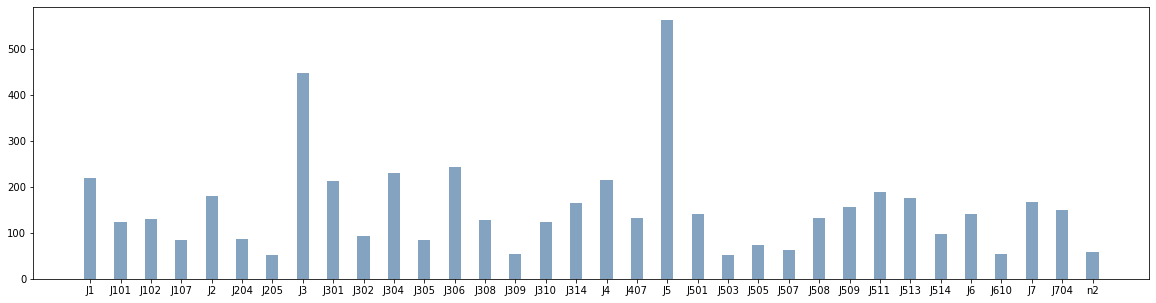

In [71]:
courses = c
values = v

fig = plt.figure(figsize = (20, 5))

plt.bar(courses, values, color=(0.2, 0.4, 0.6, 0.6),
        width = 0.4)

In [72]:
dd = pd.DataFrame(total_artist_tfidf,columns=artist_names,index=user_ids)

In [73]:
column_length = len(dd.columns)
column_name = list(dd.columns)
column_total = [ ]#每個column所有user權重加總
for i in range(column_length):
    column_list = dd[column_name[i]].to_list()
    total = 0
    for j in range(len(column_list)):
        total = total + column_list[j]
    column_total.append(total)
print(len(column_total))

82580


In [74]:
threshold = 15
arr_d = np.array(column_total)
k = list(np.where(arr_d>threshold))[0]
len(k)

33

In [75]:
c = []
v = []
for i in range(len(k)):
    c.append(column_name[k[i]])
    v.append(column_total[k[i]])

In [76]:
d = pd.DataFrame(v,columns=['tf-idf'],index=c)
d.T

,ワン・ズーチー,和泉修,ナムグン・ミン,パク・ウンビン,ジェン・イェチョン,チェ・ウン,ナ・ヘミ,コ・ボンファン,ジャオ・ヤオコー,ヤン・ティンドン[楊廷東],...,チョン・ミナ,ト・ジウォン,フー・イーシュエン,チョン・ドンユン,木村魚拓,ヤン・リン,スー・シャオトン,ダソム,ガオ・ツォンカイ,ジョンホン
tf-idf,27.115598,40.690269,16.719123,15.208648,36.211295,17.030859,17.030859,17.030859,26.292443,26.292443,...,17.030859,18.135342,36.211295,15.208648,16.706119,36.211295,26.292443,24.714762,36.211295,17.030859


In [78]:
f = np.array(v) #這段期間最有話題性的藝人
max = f.max()
index = list(np.where(f==max))[0]
for i in range(len(index)):
    print(c[index[i]])

和泉修
mari


### 不考慮時間考慮行為(加總七天後算tfidf*行為)

In [ ]:
total_genre_tfidf = np.zeros((id_length,genre_length),dtype=float)
total_artist_tfidf = np.zeros((id_length,artist_length),dtype=float)
for i in range(7):
    total_genre_tfidf = genre_tfidf[i] + total_genre_tfidf
    total_artist_tfidf = artist_tfidf[i] + total_artist_tfidf

In [ ]:
# artist_interaction_zero_arr
# genre_interaction_zero_arr
actionG = np.zeros((6,id_length,genre_length),dtype=float) #各自動作的七天加總
actionA = np.zeros((6,id_length,artist_length),dtype=float)

total_actionG_tfidf = np.zeros((id_length,genre_length),dtype=float)
total_actionA_tfidf = np.zeros((id_length,artist_length),dtype=float)
for i in range(6):
    for j in range(7):
        actionG[i] = genre_interaction_zero_arr[i][j] + actionG[i]
        actionA[i] = artist_interaction_zero_arr[i][j] + actionA[i]
for i in range(len(action_weight_list)):
    total_actionG_tfidf = total_actionG_tfidf + action_weight_list[i] * actionG[i] * total_genre_tfidf
    total_actionA_tfidf = total_actionA_tfidf + action_weight_list[i] * actionA[i] * total_artist_tfidf

## 加總七天

### 不考慮時間與行為(加總七天後算tfidf)

### 不考慮時間考慮行為(加總七天後算tfidf)